# Classification Analysis

In [79]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer
from xgboost import XGBClassifier

def fb_score(y_true, y_pred, beta):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return ((1 + beta**2) * precision * recall) / ((beta**2) * precision + recall)

def f1_func(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall)

def f2_func(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return (5 * precision * recall) / (4 * precision + recall)

def classification_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    f2 = f2_score(y_true, y_pred)
    return [accuracy, precision, recall, f1, f2]

f1_score = make_scorer(f1_func)
f2_score = make_scorer(f2_func)

base_dir = os.path.join(os.getcwd(), os.pardir)

Get the data.

In [55]:
data_path = os.path.join(base_dir, "data/altered/imputed/maps_xgboost_impute.csv")
df = pd.read_csv(data_path, index_col="X")
df

,comp_bed_9,mat_dep,mat_age,weight_16,height_16,iq,comp_noint_bed_16,comp_int_bed_16,talk_phon_wend,text_wend,...,dep_score,comp_house,tv_bed_16,creat_14,comp_games,fam_tv_eve,fam_tv_aft,fam_tv_mor,sex,birth_order
X,,,,,,,,,,,,,,,,,,,,,
1,0.0,3.000000,30.0,59.294132,181.602831,107.000000,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0
2,0.0,9.000000,26.0,32.752800,139.659500,85.000000,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,3.000000,24.0,32.667496,139.719131,45.272793,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0
4,0.0,0.000025,22.0,49.812426,160.224186,45.179386,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0.0,8.000000,31.0,62.270030,191.703227,132.000000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13730,0.0,13.000000,27.0,32.788525,139.712128,45.198166,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0
13731,0.0,6.000000,29.0,32.708584,139.544815,45.110069,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0
13732,0.0,21.000000,37.0,58.075832,169.235565,108.000000,0.0,1.0,1.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Create train and test sets. 

In [69]:
X = df.drop("has_dep_diag", axis=1)
y = df["has_dep_diag"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

`Note: we use the straify parameter to maintain the target class balance between testing and training sets.`

## Class balance

We wish to perform classification on the feature `has_dep_diag`. Our evaluation metric of choice will depend on the balance of positive and negative samples. Let's look at the count of each.

<AxesSubplot:xlabel='class', ylabel='count'>

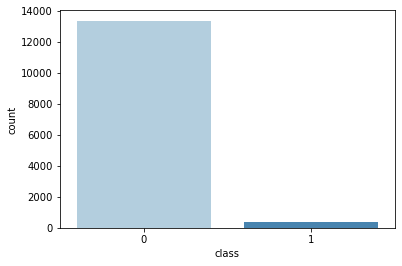

In [39]:
dep_counts = df["has_dep_diag"].value_counts()
dep_list = list(zip([0, 1], dep_counts.tolist()))

dep_df = pd.DataFrame(dep_list, columns=["class", "count"])

sns.barplot(x="class", y="count", data=dep_df, palette="Blues")

As you can see the distribution of values in this feature is massively uneven.

This is not ideal from a classification perspective, but we wouldn't really want half of the children in the study to be depressed!

Lets also get the exact ratio as this will be useful later. We call the positive class (1) the minority class and the negative class (0) the majority class.

In [51]:
sample_ratio = dep_counts[0] / dep_counts[1]

print(f"minority:majority = {dep_counts[1]}:{dep_counts[0]} (1:{sample_ratio:.0f})")

minority:majority = 389:13345 (1:34)


## Metrics for imbalanced classification

When analysing the performance of classification on the imputated data we used F1-score as our target metric. We did so as we suspected we would have imbalanced classes and so standard accuracy would not perform well. F1-score is the harmonic mean of precision and recall, so maximising the F1-score results in a classifier sensitive to both true positives and false negatives.

F1-score is an instance of the more general metric F-score, or Fβ. The equation for Fβ is as follows:

```
Fβ = ((1 + β^2) * precision * recall) / ((β**2) * precision + recall)
```

With F1 we have:

```
F1 = ((1 + 1) * precision * recall) / (1 * precision + recall)
F1 = (2 * precision * recall) / precision + recall)
```

It then follows that the F2 score would be: 

```
F2 = (1 + 4) * precision * recall) / ((4) * precision + recall)
F2 = (5 * precision * recall) / (4 * precision + recall)
```

This results in a metric which weights recall higher than precision. What this means is we have a metric that is sensitive to false negatives.

False negative sensitivity is of particular interest to us as we would rather air on the side of caution and mis-classify someone as having depression and them receive treatment than classify someone who didn't as being ok. For this reason we shall use the F2 score as our target metric for further classification analysis.

## Classification optimisation

Our previous classifier was not optimal. We shall run a randomised hyper-parameter search to find a better classifier.

First lets create the base classifier.

In [73]:
xgb = XGBClassifier(
	objective="binary:logistic",
	scale_pos_weight=sample_ratio,
	n_jobs=1,
)

`Note: we have used the sample ratio to tell XGBoost to weight the positive and negative samples correctly.`

Let's specify the search parameters.

In [68]:
params = {
	"n_estimators": [200, 500, 1000],
	"max_depth": [3, 5, 10],
	"gamma": [0.5, 1, 2],
	"min_child_weight": [1, 5, 10],
	"subsample": [0.5, 0.75, 1],
	"colsample_bytree": [0.5, 0.75, 1],
}

We shall also specify the scoring metrics.

In [74]:
scoring = [accuracy_score, precision_score, recall_score, f1_score, f2_score]

Now we can perform a search of 20 parameter permutations with 3-fold cross-validation.

In [81]:
rsearch = RandomizedSearchCV(xgb, params, scoring=f2_score, n_iter=20, cv=3)

Now we can run the parameter search.

In [82]:
rsearch.fit(X_train, y_train)

/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[09:28:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:28:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was c

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           

Now we can look at the best parameters.

In [88]:
rsearch.best_params_

{'subsample': 0.75,
 'n_estimators': 500,
 'min_child_weight': 5,
 'max_depth': 5,
 'gamma': 0.5,
 'colsample_bytree': 0.75}

`Note: as we used a random parameter search this is likely not the best results, but due to the time-complexity of using a grid search with this parameter set this shall suffice.`

Let's test the accuracy on the test set.

In [90]:
best_xgb = rsearch.best_model_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_model_'

## Classification on feature sets